<a href="https://colab.research.google.com/github/xr-cc/proj-hsg-env-chal/blob/master/code/clustering_CES3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering analysis of CES3 Bay Area data

In [51]:
# ! pip install geopandas
# ! pip install descartes

In [53]:
# ! pip install mapclassify
# ! pip install libpysal
# ! pip install esda

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
# import geopandas as gpd
import pandas as pd
import numpy as np
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

# import pysal as ps
# from pysal.contrib.viz import mapping as maps

# import mapclassify as mc
# import libpysal as lps
# from esda.moran import Moran,Moran_Local

from matplotlib import colors

from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn import metrics


In [3]:
# grant access to Google Drive
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# os.listdir("/content/drive/My Drive/")

In [5]:
# load data

dataPath = "/content/drive/My Drive/DS4A/DS4A_Team 31/data/CES3/"
xls = pd.ExcelFile(dataPath+"CES3 - Bay Area.xlsx")
sheets = xls.sheet_names
print(sheets)


['CES 3.0 (2018 Update)', 'Data Dictionary', 'Missing&NAData', 'Demographic profile']


In [7]:
# load dataframes

df = pd.read_excel(xls, sheet_name=sheets[0])
df_dict = pd.read_excel(xls, sheet_name=sheets[1],skiprows=range(0,6)).dropna(thresh=2)
df_demo = pd.read_excel(xls, sheet_name=sheets[3], header=None,
                        names=['Census Tract','CES 3.0 Score','CES 3.0 Percentile','CES 3.0 Percentile Range','Total Population',
                               'California County','Age:<10','Age:11-64','Age:>65', 'Race:Hispanic','Race:White','Race:AfricanAmerican',
                               'Race:NativeAmerican','Race:Aisan','Race:Other'],skiprows=[0]).dropna()

df_dict_temp = df_dict.dropna()
pop_char = df_dict_temp[df_dict_temp['CalEnviroScreen Category'].str.contains('Population')]['Variable Name'].drop_duplicates()
pop_char = [v.rstrip() for v in pop_char]
env_char = df_dict_temp[df_dict_temp['CalEnviroScreen Category'].str.contains('Pollution')]['Variable Name'].drop_duplicates()
env_char = [v.rstrip() for v in env_char]
# var_char.insert(0,'Census ID')
print(pop_char)
print(env_char)

['Asthma', 'Asthma Pctl', 'Low Birth Weight', 'Low Birth Weight Pctl', 'Cardiovascular Disease', 'Cardiovascular Disease Pctl', 'Education', 'Education Pctl', 'Linguistic Isolation', 'Linguistic Isolation Pctl', 'Poverty', 'Unemployment', 'Unemployment Pctl', 'Housing Burden', 'Housing Burden Pctl']
['Ozone', 'Ozone Pctl', 'PM2.5', 'PM2.5 Pctl', 'Diesel PM', 'Diesel PM Pctl', 'Drinking Water', 'Drinking Water Pctl', 'Pesticides', 'Pesticides Pctl', 'Tox. Release', 'Tox. Release Pctl', 'Traffic', 'Traffic Pctl', 'Cleanup Sites', 'Cleanup Sites Pctl', 'Groundwater Threats', 'Groundwater Threats Pctl', 'Haz. Waste', 'Haz. Waste Pctl', 'Imp. Water Bodies', 'Imp. Water Bodies Pctl', 'Solid Waste', 'Solid Waste Pctl']


In [30]:
df.head()

,Census ID,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,CES 3.0 Score,CES 3.0 Percentile,CES 3.0 \nPercentile Range,SB 535 Disadvantaged Community,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6001400100,4001.0,2937,Alameda,94704,Berkeley,-122.231903,37.867595,3.970573,1.866566,1-5% (lowest scores),No,0.029592,7.57934,8.697944,30.701098,27.436933,80.958307,70.599583,4.465511,0.0,0.0,485.311211,50.299327,929.74,64.018047,4.5,42.174389,4.05,27.077127,6.0,97.81279,2,29.250497,1.0,32.798868,37.942971,4.673549,39.688861,18.50,6.308440,2.99,8.676150,3.01,0.723102,1.7,4.277063,3.8,28.622850,7.6,3.570082,NaN,NaN,8.5,8.123889,8.192184,0.849584,0.819776
1,6001400200,4002.0,1974,Alameda,94618,Oakland,-122.249576,37.848171,1.810257,0.252239,1-5% (lowest scores),No,0.029592,7.57934,8.697944,30.701098,42.190000,94.399502,70.599583,4.465511,0.0,0.0,442.468040,48.852582,1392.34,80.574007,0.0,0.000000,20.55,71.714664,0.0,0.00000,0,0.000000,0.0,0.000000,30.168791,3.715980,20.124456,24.27,14.636579,1.24,0.435730,3.98,4.525620,1.5,3.419127,0.0,0.000000,11.2,8.988058,2.2,1.129585,4.0,0.774308,4.697429,0.487155,0.063060
2,6001400300,4003.0,4865,Alameda,94618,Oakland,-122.254436,37.840598,12.041135,17.631479,15-20%,No,0.029592,7.57934,8.697944,30.701098,42.190000,94.399502,70.599583,4.465511,0.0,0.0,426.127435,48.291344,1207.30,75.410452,0.9,12.860270,35.25,85.187024,0.0,0.00000,0,0.000000,0.0,0.000000,31.379081,3.865055,22.962041,37.93,38.311931,4.13,29.232347,4.42,7.505299,5.0,19.707292,8.9,54.939341,14.3,14.833438,8.8,45.970301,16.0,39.870526,30.040353,3.115385,20.267373
3,6001400400,4004.0,3703,Alameda,94609,Oakland,-122.257463,37.848211,10.912634,15.020810,15-20%,No,0.029592,7.57934,8.697944,30.701098,42.190000,94.399502,70.599583,4.465511,0.0,0.0,444.957438,48.964829,1153.54,73.680912,0.0,0.000000,38.75,87.040715,0.0,0.00000,0,0.000000,0.0,0.000000,30.544733,3.762286,20.883634,60.86,69.928937,3.98,25.759323,4.89,11.569630,6.1,24.287156,2.3,16.651113,16.8,19.949717,3.3,3.553750,15.3,36.481340,27.968623,2.900533,17.379241
4,6001400500,4005.0,3517,Alameda,94609,Oakland,-122.264745,37.848517,18.549441,34.581914,30-35%,No,0.029592,7.57934,8.697944,30.701098,42.190000,94.399502,70.599583,4.465511,0.0,0.0,448.931402,49.102020,668.28,47.549818,3.5,35.078439,21.60,73.022178,0.0,0.00000,0,0.000000,0.0,0.000000,29.473116,3.630292,18.469197,110.37,94.651540,5.59,67.986672,7.55,44.458297,3.2,11.203634,2.3,16.651113,25.1,36.379635,6.5,24.660490,19.9,58.644326,49.270005,5.109628,48.846008


In [18]:
# data cleaning: use both enviromental and population variables
X_df = df[env_char+pop_char]
X_df = X_df.dropna()
indices = X_df.index.tolist()
print(len(X_df),"out of",len(df),"rows are valid data")

1507 out of 1581 rows are valid data


In [19]:
X = X_df.values
n, m = X.shape
print("n={},m={}".format(n,m))

n=1507,m=39


### Train algorithm and test clustering on different data

In [50]:
X_train, X_test, indices_train, indices_test = train_test_split(X, indices, test_size=0.2, random_state=42)
print("Train size",X_train.shape)
print("Test size",X_test.shape)

Train size (1205, 39)
Test size (302, 39)


In [24]:
# standardizing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [66]:
# Clutering methods:
n_cluster = 5
methods = {'kmeans':KMeans(n_clusters=n_cluster, random_state=0),
           'spectral': SpectralClustering(n_clusters=n_cluster,assign_labels="discretize",random_state=0), # not working
           'GMM':GaussianMixture(n_components=n_cluster),
           'agglomerative':AgglomerativeClustering(n_clusters=n_cluster,linkage='ward')}


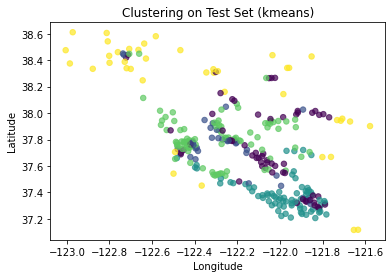

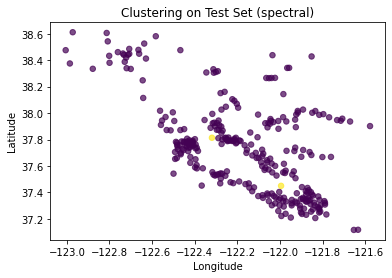

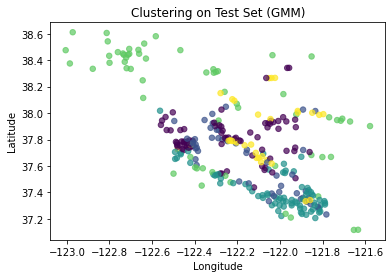

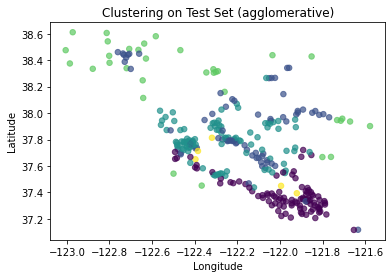

In [68]:
for method in methods.keys():
  clustering = methods[method].fit(X_train_scaled)

  # perform clustering on the test set
  if method in ['spectral','agglomerative']:
    y_clustered = clustering.fit_predict(scaler.transform(X_test))
  else:
    y_clustered = clustering.predict(scaler.transform(X_test))

  # plot clustering results for test data spatially
  plt.figure()
  plt.scatter(df.loc[indices_test, 'Longitude'], df.loc[indices_test, 'Latitude'], 
              c=y_clustered, s=30, cmap='viridis',alpha=0.7)
  plt.title("Clustering on Test Set ({})".format(method))
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')

### Clustering on the entire set (no train-test split)


In [69]:
# standardizing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

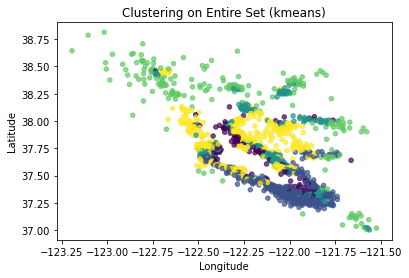

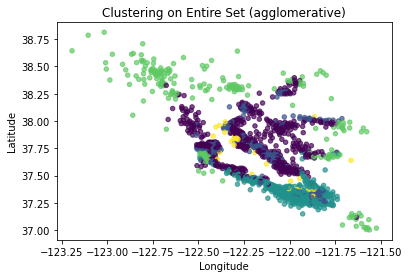

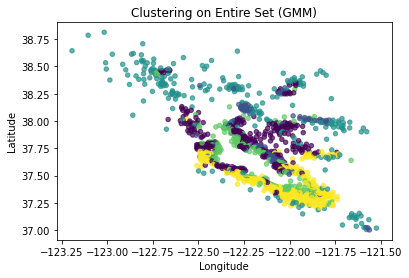

In [71]:
for method in ['kmeans','agglomerative','GMM']:
  clustering = methods[method].fit(X_scaled)

  if method=="GMM":
    y_clustered = clustering.predict(X_scaled)
  else:
    y_clustered = clustering.labels_

  # perform clustering on the test set
  # if method in ['spectral','agglomerative']:
  #   y_clustered = clustering.fit_predict(scaler.transform(X_test))
  # else:
  #   y_clustered = clustering.predict(scaler.transform(X_test))

  # plot clustering results for test data spatially
  plt.figure()
  plt.scatter(df.loc[indices, 'Longitude'], df.loc[indices, 'Latitude'], 
              c=y_clustered, s=20, cmap='viridis',alpha=0.7)
  plt.title("Clustering on Entire Set ({})".format(method))
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')

In [ ]:
# Plot on map
# # load geo dataframe
# gdf = gpd.read_file(dataPath+"CES3June2018Update.shp")
# gdf = gdf[gdf['tract'].isin(df['Census ID'])].reset_index(drop=True).rename(columns={'tract': 'Census ID'})

# # join dataframes
# gdf = gdf.merge(df[var_char], on='Census ID')
# gdf.head()